In [1]:
#Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from scipy.stats import linregress
import numpy as np
import datetime

#File to load
cab_data_path = "Resources/Kaggle_Data/cab_rides.csv"

#Read the Cab data
cab_df = pd.read_csv(cab_data_path)

#Display the cab_df file for preview
cab_df

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL
...,...,...,...,...,...,...,...,...,...,...
693066,1.00,Uber,1543708385534,North End,West End,13.0,1.0,616d3611-1820-450a-9845-a9ff304a4842,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL
693067,1.00,Uber,1543708385534,North End,West End,9.5,1.0,633a3fc3-1f86-4b9e-9d48-2b7132112341,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX
693068,1.00,Uber,1543708385534,North End,West End,NaN,1.0,64d451d0-639f-47a4-9b7c-6fd92fbd264f,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi
693069,1.00,Uber,1543708385534,North End,West End,27.0,1.0,727e5f07-a96b-4ad1-a2c7-9abc3ad55b4e,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV


In [2]:
#Clean Data

#Convert the 13-digit timestamp to a date-time format

cab_df['Time Stamp'] = pd.to_datetime(cab_df['time_stamp']/1000, unit = 's')
cab_df['Day of Week'] = cab_df['Time Stamp'].dt.dayofweek

#Remove columns that are not applicable to analysis
cleaned_cab_df = cab_df[['distance', 'cab_type', 'destination', 'source', 'price', 'Day of Week']]
dist_price_df = cab_df[['cab_type','price','distance']]

#Rename columns
cleaned_cab_df = cleaned_cab_df.rename(columns = {'distance': 'Distance',
                                                  'cab_type': 'Company',
                                                  'destination': 'Destination',
                                                  'source': 'Source',
                                                  'price': 'Price'})

cleaned_cab_df

,Distance,Company,Destination,Source,Price,Day of Week
0,0.44,Lyft,North Station,Haymarket Square,5.0,6
1,0.44,Lyft,North Station,Haymarket Square,11.0,1
2,0.44,Lyft,North Station,Haymarket Square,7.0,2
3,0.44,Lyft,North Station,Haymarket Square,26.0,4
4,0.44,Lyft,North Station,Haymarket Square,9.0,3
...,...,...,...,...,...,...
693066,1.00,Uber,North End,West End,13.0,5
693067,1.00,Uber,North End,West End,9.5,5
693068,1.00,Uber,North End,West End,NaN,5
693069,1.00,Uber,North End,West End,27.0,5


In [3]:
cleaned_cab_df = cleaned_cab_df.dropna(how="any")

In [4]:
cleaned_cab_df

,Distance,Company,Destination,Source,Price,Day of Week
0,0.44,Lyft,North Station,Haymarket Square,5.0,6
1,0.44,Lyft,North Station,Haymarket Square,11.0,1
2,0.44,Lyft,North Station,Haymarket Square,7.0,2
3,0.44,Lyft,North Station,Haymarket Square,26.0,4
4,0.44,Lyft,North Station,Haymarket Square,9.0,3
...,...,...,...,...,...,...
693065,1.00,Uber,North End,West End,9.5,5
693066,1.00,Uber,North End,West End,13.0,5
693067,1.00,Uber,North End,West End,9.5,5
693069,1.00,Uber,North End,West End,27.0,5


In [5]:
df_grouped_cab = cleaned_cab_df.groupby(["Company"])

total_miles = df_grouped_cab["Distance"].sum()
total_fare = df_grouped_cab["Price"].sum()
max_miles = df_grouped_cab["Distance"].max()
max_fare = df_grouped_cab["Price"].max()
fare_per_mile = total_fare/total_miles
total_trips = df_grouped_cab["Company"].count()
average_fare_per_trip = total_fare/total_trips
average_mile_per_trip = total_miles/total_trips

df_cab_summary = pd.DataFrame({"Total Miles": total_miles,
                                   "Total Fare": total_fare,
                                   "Total Trips": total_trips,
                                   "Fare Per Mile": fare_per_mile,
                                   "Maximum Distance": max_miles,
                                   "Maximum Fare": max_fare,
                                   "Avg Fare Per Trip": average_fare_per_trip,
                                   "Avg Miles Per Trip": average_mile_per_trip})

format_mapping = {'Total Miles': '{:,.2f}', 'Total Fare': '${:,.2f}','Total Trips': '{:,.0f}',
                 'Fare Per Mile': '${:,.3f}', 'Total Miles': '{:,.2f}', 'Maximum Fare': '${:,.2f}',
                  'Avg Fare Per Trip': '${:,.3f}','Avg Miles Per Trip': '{:,.3f}'}

for key, value in format_mapping.items():
    df_cab_summary[key] = df_cab_summary[key].apply(value.format)

df_cab_summary

,Total Miles,Total Fare,Total Trips,Fare Per Mile,Maximum Distance,Maximum Fare,Avg Fare Per Trip,Avg Miles Per Trip
Company,,,,,,,,
Lyft,"672,293.79","$5,333,957.98","307,408",$7.934,6.33,$97.50,$17.351,2.187
Uber,"724,402.25","$5,221,435.00","330,568",$7.208,7.86,$89.50,$15.795,2.191


In [6]:
df_uber_trips = cleaned_cab_df.loc[(cleaned_cab_df["Company"] == 'Uber')]
df_lyft_trips = cleaned_cab_df.loc[(cleaned_cab_df["Company"] == 'Lyft')]


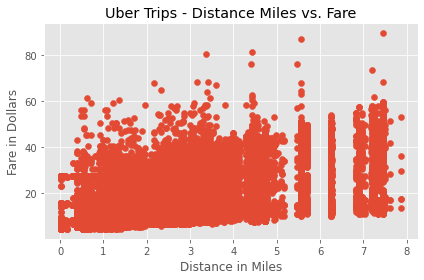

In [15]:
# Set Plot Attributes
plt.style.use('ggplot')
plt.title("Uber Trips - Distance Miles vs. Fare")

x=df_uber_trips['Distance']
y=df_uber_trips['Price']
plt.xlabel('Distance in Miles')
plt.ylabel('Fare in Dollars')
plt.scatter(x,y)
plt.tight_layout()

#Save the image
plt.savefig('Figures/Uber_Distance_vs_Fare.png')

plt.show()




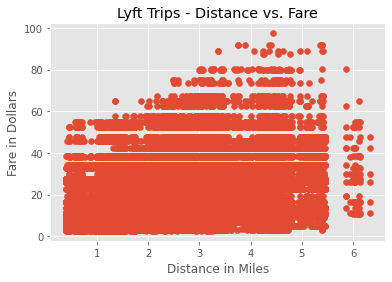

In [16]:
plt.style.use('ggplot')
plt.title("Lyft Trips - Distance vs. Fare")

x=df_lyft_trips['Distance']
y=df_lyft_trips['Price']
plt.xlabel('Distance in Miles')
plt.ylabel('Fare in Dollars')

plt.scatter(x,y)

#Save the image
plt.savefig('Figures/Lyft_Distance_vs_Fare.png')
